# Math 610: Homework 2
**Neal Kuperman**


In [244]:
#%% Packages
import ISLP 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as smf
from IPython.display import display, HTML
from lin_reg_plots import LinearRegDiagnostic


In [245]:
def summarize(model, vars = [], verbose = True):
    if isinstance(model.params, np.ndarray):
        params = model.params
        if len(vars) != (len(params) - 1):
            if verbose:
                print("Warning: The number of variables does not match the number of parameters")
            vars = ["intercept"] + [f"x{i}" for i in range(len(params) - 1)]
    else:
        params = model.params.values
        vars = model.params.index.to_list()
    
    tvalues = np.round(model.tvalues, 4)
    pvalues = np.round(model.pvalues, 4)
    std_err = np.round(model.bse, 4)

    param_summary = pd.DataFrame(index=vars)
    param_summary["coef"] = params
    param_summary["t value"] = tvalues
    param_summary["p value"] = pvalues
    param_summary["std err "] = std_err
    

    r_squared = np.round(model.rsquared, 4)
    F_stat = np.round(model.fvalue, 4)  
    # model_summary = pd.DataFrame(columns=["R-squared", "F-statistic"])
    model_summary = pd.DataFrame({"R-squared": [r_squared], "F-statistic": [F_stat]}, index = ["value"])

    return param_summary, model_summary

def calc_leverage(x):
    """
    Observations with high leverage have an unusual value for xi. High leverage observations tend to have
    a sizable impact on the estimated regression line.   

    SLR
    hi = 1/n + (xi - x_bar)^2 / sum((xi - x_bar)^2)

    MLR

    Hii = diag(H) 
        H = X^T (X^T X)^-1 X
    """

    H = x @ np.linalg.inv(x.T @ x) @ x.T
    leverage_points = np.diag(H)
    return leverage_points

def find_high_leverage_points(x):
    """
    Observations with high leverage have an unusual value for xi. High leverage observations tend to have

    hii > 2p/n
        p = number of predictors
        n = number of observations
    """
    leverage_points = calc_leverage(x)
    high_leverage_points = leverage_points > 2 * x.shape[1]/x.shape[0]
    index = np.where(high_leverage_points)[0]
    return index, leverage_points[index]


---
## Problem: ISLP 3.10

This question should be answered using the Carseats data set.

**(a)** Fit a multiple regression model to predict Sales using Price, Urban, and US.

**(b)** Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

**(c)** Write out the model in equation form, being careful to handle the qualitative variables properly.

**(d)** For which of the predictors can you reject the null hypothesis $H_0 : \beta_j = 0$?

**(e)** On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

**(f)** How well do the models in (a) and (e) fit the data?

**(g)** Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

**(h)** Is there evidence of outliers or high leverage observations in the model from (e)?



---
## Solution

The data is a simulated data set containing sales of child car seats at 400 different stores. Information on the data set can be found on the [ISLP github](https://islp.readthedocs.io/en/latest/datasets/Carseats.html)



| Variable | Description |
|----------|-------------|
| **Sales** | Unit sales (in thousands) at each location |
| **CompPrice** | Price charged by competitor at each location |
| **Income** | Community income level (in thousands of dollars) |
| **Advertising** | Local advertising budget for company at each location (in thousands of dollars) |
| **Population** | Population size in region (in thousands) |
| **Price** | Price company charges for car seats at each site |
| **ShelveLoc** | Factor with levels Bad, Good, Medium — quality of shelving location |
| **Age** | Average age of the local population |
| **Education** | Education level at each location |
| **Urban** | Factor (No/Yes) — whether store is in urban or rural location |
| **US** | Factor (No/Yes) — whether store is in the US or not |

In [246]:
# Load Carseats data and print summary info

carseats = ISLP.load_data('Carseats')
carseats.head()

print("Carseats head")
print("="*60)
print(carseats.head())
print("\n")

print("Summary")
print("="*60)
summary = pd.DataFrame({
    'dtype': carseats.dtypes,
    'null': carseats.isna().sum(),
    'unique': carseats.nunique()
})
print(summary)

quant_cols = carseats.select_dtypes(include=['number']).columns
cat_cols = carseats.select_dtypes(include=['category']).columns

# convert categorical columns to dummy variables. Creates a new column for each category level for each categorical column.
carseats = pd.get_dummies(carseats, columns=cat_cols, dtype=float)

Carseats head
   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


Summary
                dtype  null  unique
Sales         float64     0     336
CompPrice       int64     0      73
Income          int64     0      98
Advertising     int64     0      28
Population      int64     0     275
Price           int64     0     101
ShelveLoc    category     0       3
Age             int64     0      56
Education       int64     0

**(a)** Fit a multiple regression model to predict Sales using Price, Urban, and US.


In [247]:
# Must add an intercept column to the design matrix when using statsmodels.api.OLS

X = carseats[["Price", "Urban_Yes", "US_Yes"]]
X.insert(0, 'Intercept', 1.0)
y = carseats["Sales"]

model = smf.OLS(y, X).fit()
print(model.summary())
# print(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           2.39e-23
Time:                        23:38:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0435      0.651     20.036      0.0

**(b)** Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!
<!-- 
Price: Price company charges for car seats at each site
Urban_Yes: the store is in an urban location
US_Yes: Yhe store is in the US
-->

- Price: Sales is negatively related to price, with sales decreasing by 54 units per dollar increase in price
- Urban_Yes: There is not a significant statistical relationship between sales and whether or not a store is in an urban location
- US_Yes: There is a positive relationship between price and whether a store is located in the US or not. On average, a store located in the US will sell 1200 more units than if they were located outside the US.

**(c)** Write out the model in equation form, being careful to handle the qualitative variables properly.

$$\text{Sales} = -0.0545 * \text{Price} + -0.0219 * \text{Urban\_Yes} + 1.2006 * \text{US\_Yes}$$

**(d)** For which of the predictors can you reject the null hypothesis $H_0 : \beta_j = 0$?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The Urban_Yes predictor has a P value of 0.936, meaning we can reject the null hypothesis for it. We can not reject the null hypothesis for any of the other variables

**(e)** On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.


In [248]:
# OLS w/ only Price and US_Yes
X = carseats[["Price", "US_Yes"]]
X.insert(0, 'Intercept', 1.0)
y = carseats["Sales"]

model = smf.OLS(y, X).fit()
print(model.summary())
# print(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           2.66e-24
Time:                        23:38:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

**(f)** How well do the models in (a) and (e) fit the data?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Models a and e fit the data equally poorly. Both have an $\text{R}^2$ value of 0.239

**(g)** Using the model from (e), obtain 95% confidence intervals for the coefficient(s).



In [249]:
model.conf_int(alpha=0.05)



,0,1
Intercept,11.79032,14.271265
Price,-0.06476,-0.044195
US_Yes,0.69152,1.707766


**(h)** Is there evidence of outliers or high leverage observations in the model from (e)?

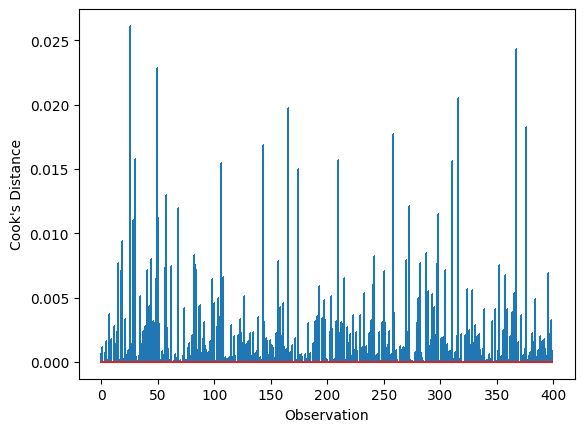

In [250]:
index, high_leverage_points = find_high_leverage_points(X.values)
lvg_df = pd.DataFrame({"index": index, "high_leverage_points": high_leverage_points})
# print(lvg_df.to_latex(index=False))

# Get influence measures
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]  # [0] is the values, [1] is p-values

# Plot Cook's D
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
# plt.axhline(y=4/len(y), color='r', linestyle='--', label='4/n threshold')
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
# plt.legend()
plt.savefig("../images/3_10_h_cooks_d.png")

plt.show()



---
## ISLP 3.14

This problem focuses on the *collinearity* problem.

**(a)** Perform the following commands in Python:

```python
rng = np.random.default_rng(10)
x1 = rng.uniform(0, 1, size=100)
x2 = 0.5 * x1 + rng.normal(size=100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + rng.normal(size=100)
```

The last line corresponds to creating a linear model in which y is a function of x1 and x2. Write out the form of the linear model. What are the regression coefficients?

**(b)** What is the correlation between x1 and x2? Create a scatterplot displaying the relationship between the variables.

**(c)** Using this data, fit a least squares regression to predict y using x1 and x2. Describe the results obtained. What are $\hat{\beta}_0$, $\hat{\beta}_1$ and $\hat{\beta}_2$? How do these relate to the true $\beta_0$, $\beta_1$ and $\beta_2$? Can you reject the null hypothesis $H_0 : \beta_1 = 0$? How about the null hypothesis $H_0 : \beta_2 = 0$?

**(d)** Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_1 = 0$?

**(e)** Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_2 = 0$?

**(f)** Do the results obtained in (c)-(e) contradict each other? Explain your answer.

**(g)** Suppose we obtain one additional observation, which was unfortunately mismeasured. We use the function `np.concatenate()` to add this additional observation to each of x1, x2 and y.

```python
x1 = np.concatenate([x1, [0.1]])
x2 = np.concatenate([x2, [0.8]])
y = np.concatenate([y, [6]])
```

Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.


### Solution

(a)

In [251]:
# ISLP 3.14 (a)
np.random.seed(5)
rng = np.random.default_rng(10)
x1 = rng.uniform(0, 1, size=100)
x2 = 0.5 * x1 + rng.normal(size=100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + rng.normal(size=100)


The linear model has the form
$$ y = 2 + 2x_1 + 0.3x_2 + \epsilon $$
and 
- $\beta_0 = 2$
- $\beta_1 = 2$
- $\beta_2 = 0.3$

**(b)** What is the correlation between x1 and x2? Create a scatterplot displaying the relationship between the variables.

$$corr(x_1, x_2) = \frac{Cov(x_1x_2)}{\sigma_{x_1} * \sigma_{x_2}} = \frac{E[(x_1 - \overline{x_1})(x_2 - \overline{x_2})]}{\sigma_{x_1} * \sigma_{x_2}} = \frac{\sum_{i=1}^{n}(x_{1i} - \bar{x}_1)(x_{2i} - \bar{x}_2)}{\sqrt{\sum_{i=1}^{n}(x_{1i} - \bar{x}_1)^2 \cdot \sum_{i=1}^{n}(x_{2i} - \bar{x}_2)^2}}$$

Correlation between x1 and x2: 0.772


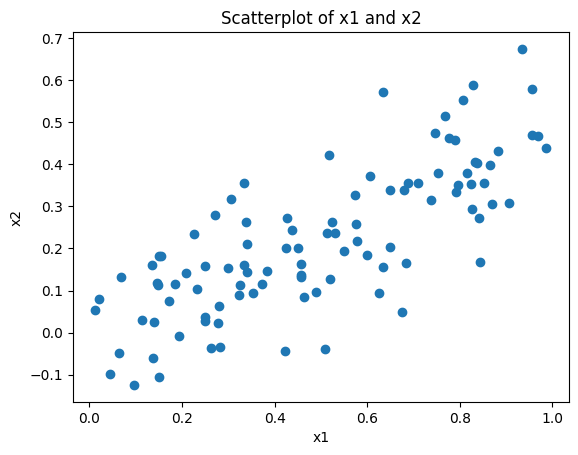

In [252]:
# Manual calculation of correlation between x1 and x2. Can also use many built-in functions
x1_mean = np.mean(x1)
x2_mean = np.mean(x2)

numerator = np.sum((x1 - x1_mean) * (x2 - x2_mean))
denominator = np.sqrt(np.sum((x1 - x1_mean)**2) * np.sum((x2 - x2_mean)**2))

correlation = numerator / denominator
print(f"Correlation between x1 and x2: {correlation:.3f}")

plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatterplot of x1 and x2')
plt.show()



**(c)** Using this data, fit a least squares regression to predict y using x1 and x2. Describe the results obtained. What are $\hat{\beta}_0$, $\hat{\beta}_1$ and $\hat{\beta}_2$? How do these relate to the true $\beta_0$, $\beta_1$ and $\beta_2$? Can you reject the null hypothesis $H_0 : \beta_1 = 0$? How about the null hypothesis $H_0 : \beta_2 = 0$?


In [253]:
# OLS w/ x1 and x2
intercept = np.ones(len(x1))
X = np.column_stack((intercept, x1, x2))
y = y
model = smf.OLS(y, X).fit()
print(model.summary())
# print(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     19.89
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           5.76e-08
Time:                        23:38:25   Log-Likelihood:                -130.62
No. Observations:                 100   AIC:                             267.2
Df Residuals:                      97   BIC:                             275.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9579      0.190     10.319      0.0

The linear model obtained from the OLS is
$$ y = 1.9579 + 1.6154x_1 + 0.9428x_2$$
and 
| Variable | True | OLS Model |
|----------|------|-----------|
| **$\beta_0$** | 2.0 | 1.9579 |
| **$\beta_2$** | 2.0 | 1.6154 |
| **$\beta_2$** | 0.3 | 0.9428 |

We can reject the null hypothesis $H_0: \beta_1 = 0$ as its t value is large ($t_{\beta_1} = 3.065$) and P value is small ($P_{\beta_1} = 0.003$). However, we can not reject the null hypothesis $H_0: \beta_2 = 0$ because its t value is less than 2 ($t_{\beta_2} = 1.134$) along with a large P value ($P_{\beta_2} = 0.259$)

<br>

**(d)** Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_1 = 0$?

In [254]:
# OLS w/ only x1
intercept = np.ones(len(x1))
X = np.column_stack((intercept, x1))
y = y
model = smf.OLS(y, X).fit()
print(model.summary())
# print(model.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     38.39
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           1.37e-08
Time:                        23:38:25   Log-Likelihood:                -131.28
No. Observations:                 100   AIC:                             266.6
Df Residuals:                      98   BIC:                             271.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9371      0.189     10.242      0.0

The goodness of fit of the least squares regression did not change meaningfully when we elmiited x2 as a predictor variable ($R^2_{x1,x2} = 0.291$, $R^2_{x1} = 0.281$). We can reject the null hypothesis $H_0: \beta_1 = 0$ due to the large t value and small P value for x1

<br>

**(e)** Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_2 = 0$?


In [255]:
# OLS w/ only x2
intercept = np.ones(len(x1))
X = np.column_stack((intercept, x2))
y = y
model = smf.OLS(y, X).fit()
print(model.summary())
# print(model.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     27.99
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           7.43e-07
Time:                        23:38:25   Log-Likelihood:                -135.24
No. Observations:                 100   AIC:                             274.5
Df Residuals:                      98   BIC:                             279.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3239      0.154     15.124      0.0

The goodness of fit of the least squares regression with only x2 included did not change meaningfully when we elmiited x2 as a predictor variable ($R^2_{x1,x2} = 0.291$, $R^2_{x2} = 0.222$). We can reject the null hypothesis $H_0: \beta_2 = 0$ due to the large t value and small P value for x2

<br>

**(f)** Do the results obtained in (c)-(e) contradict each other? Explain your answer.

They do not contradict each other, x1 and x2 explain the variance in y equally well (poorly) with $R^2_{x1} = 0.281$ and $R^2_{x2} = 0.222$. Additionally the null hypothesis can not be rejected when only including 1 predictor, either x1 or x2. These outcomes can be explained by x1 and x2 being colinear (they are highly coorelated).

<br> 

**(g)** Suppose we obtain one additional observation, which was unfortunately mismeasured. We use the function `np.concatenate()` to add this additional observation to each of x1, x2 and y. Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.


In [256]:

x1_new = np.concatenate([x1, [0.1]])
x2_new = np.concatenate([x2, [0.8]])
y_new = np.concatenate([y, [6]])

intercept = np.ones(len(x1_new))
X_full = np.column_stack((intercept, x1_new, x2_new))
X_x1 = np.column_stack((intercept, x1_new))
X_x2 = np.column_stack((intercept, x2_new))

model_full = smf.OLS(y_new, X_full).fit()
model_x1 = smf.OLS(y_new, X_x1).fit()
model_x2 = smf.OLS(y_new, X_x2).fit()
print("Full Model")
print("="*60)
param_summary_full, model_summary_full = summarize(model_full, verbose=False)
display(param_summary_full)
display(model_summary_full)
# print(model_full.summary())
print("\n")
print("x1 Model")
print("="*60)
param_summary_x1, model_summary_x1 = summarize(model_x1, verbose=False)
display(param_summary_x1)
display(model_summary_x1)
print("\n")
print("x2 Model")
print("="*60)
param_summary_x2, model_summary_x2 = summarize(model_x2, verbose=False)
display(param_summary_x2)
display(model_summary_x2)


Full Model


,coef,t value,p value,std err
intercept,2.061791,10.7201,0.0000,0.1923
x0,0.857545,1.8383,0.0690,0.4665
x1,2.266323,3.2160,0.0018,0.7047


,R-squared,F-statistic
value,0.2916,20.1727




x1 Model


,coef,t value,p value,std err
intercept,2.073941,10.3098,0.0,0.2012
x0,1.876046,5.2360,0.0,0.3583


,R-squared,F-statistic
value,0.2169,27.4159




x2 Model


,coef,t value,p value,std err
intercept,2.284012,15.0879,0.0,0.1514
x0,3.145849,6.0082,0.0,0.5236


,R-squared,F-statistic
value,0.2672,36.0984


[ 15 100]
[0.07100205 0.34767162]
[100]
[1.28798756]


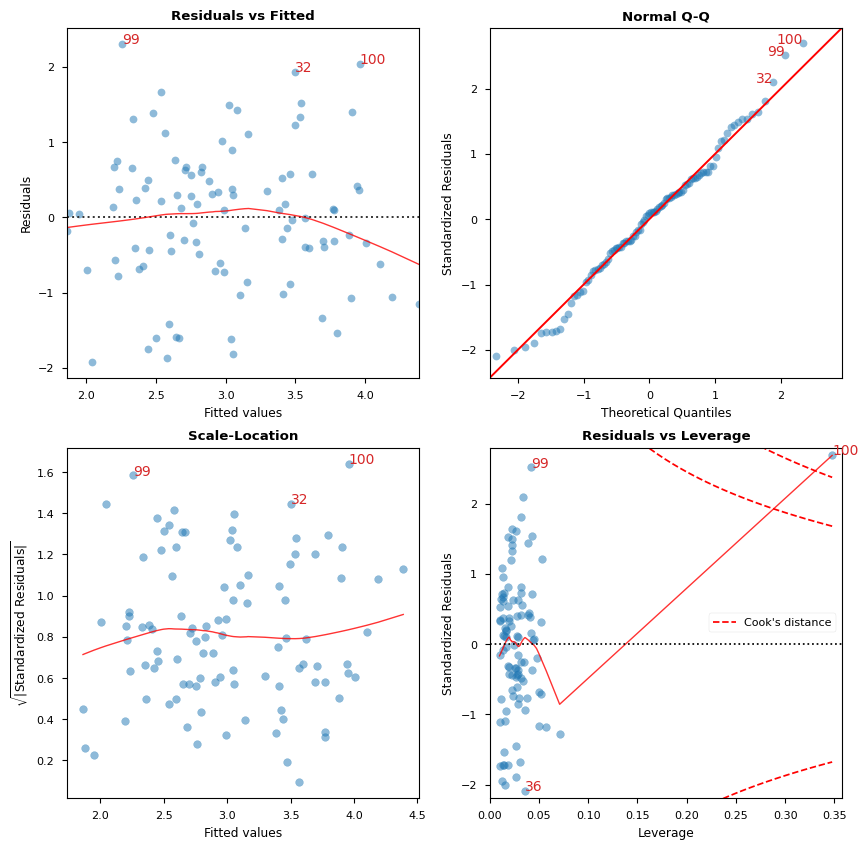

  Features  VIF Factor
1       x1        1.86
2       x2        1.86
0    const        4.25


In [257]:
index, high_leverage_points = find_high_leverage_points(X_full)
print(index)
print(high_leverage_points)

influential_stats = model_full.get_influence()
cooks_D = influential_stats.cooks_distance[0] 
influential_pts_index = np.where(cooks_D > 1)[0]
influential_pts_vals = cooks_D[influential_pts_index]

print(influential_pts_index)
print(influential_pts_vals)

cls = LinearRegDiagnostic(model_full)
vif, fig, ax = cls()
print(vif)


---
## ISLP 3.15 (a, b, d)

This problem involves the Boston data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set. In other words, per capita crime rate is the response, and the other variables are the predictors.

**(a)** For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.

**(b)** Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$?

**(d)** Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form

$$y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$$


### Solution

**(a)** For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.


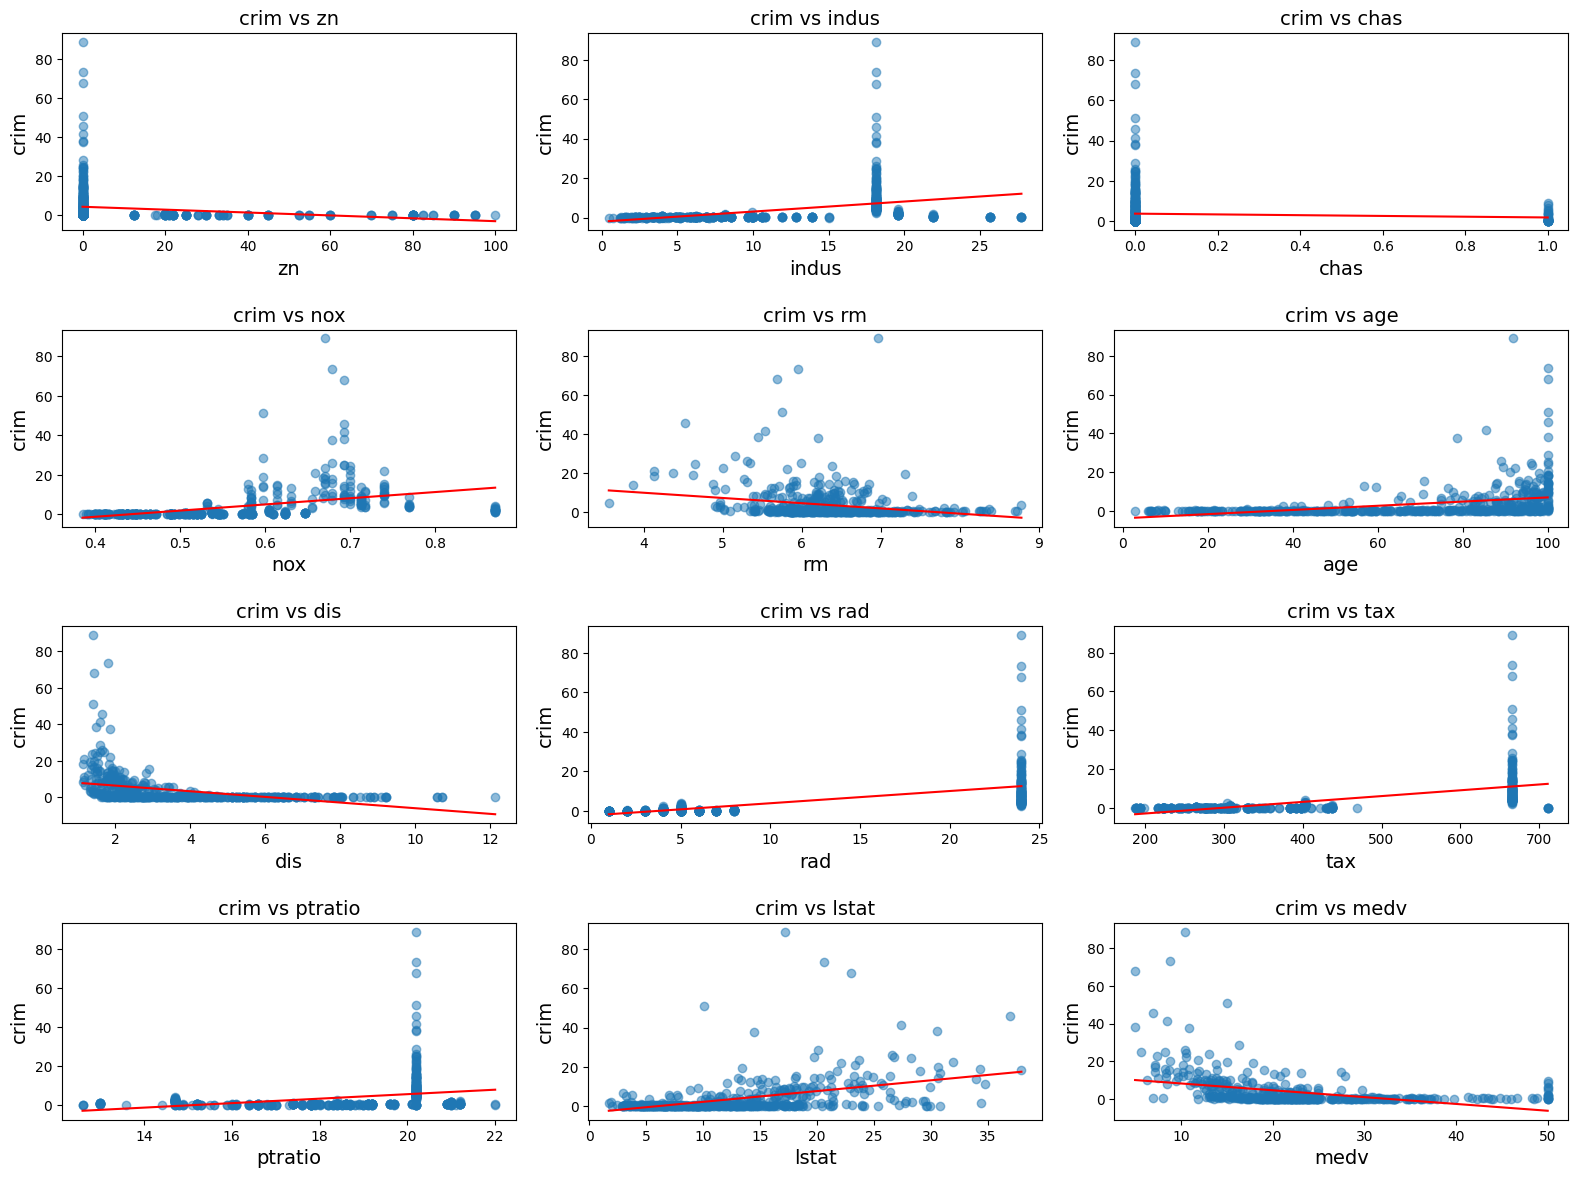

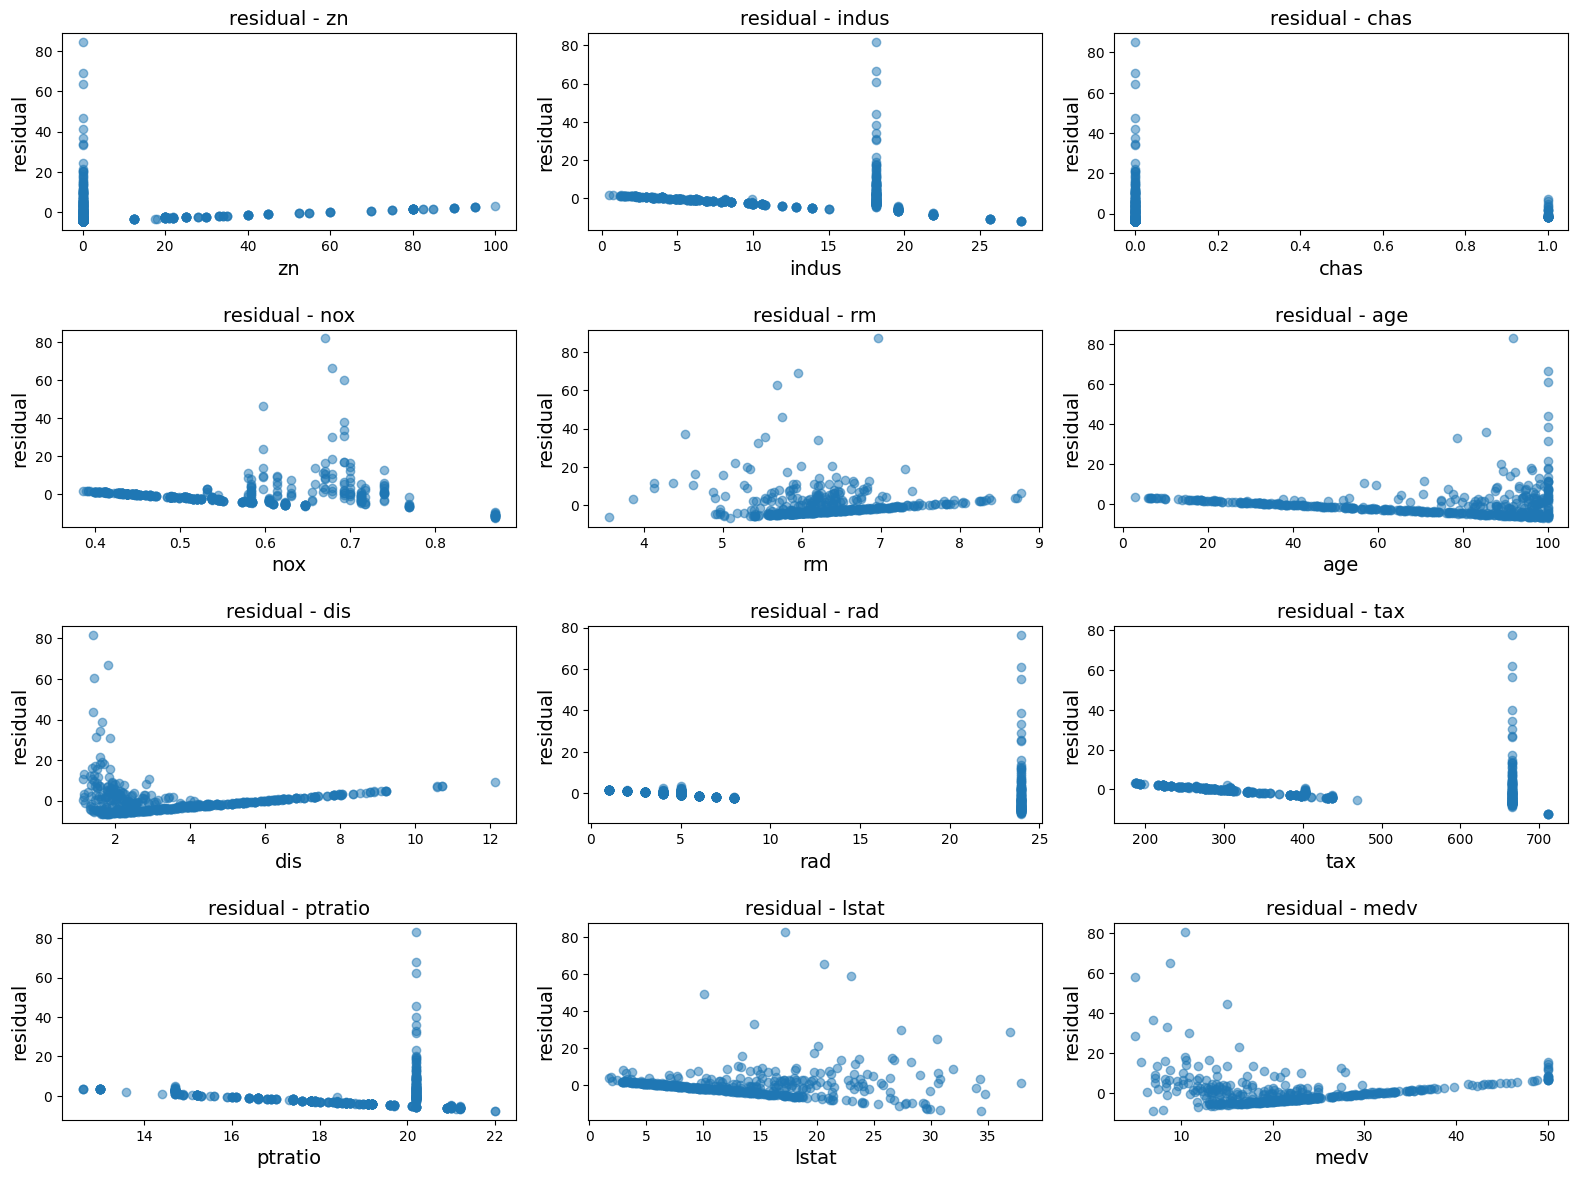

   predictor  r_squared
7        rad   0.391257
8        tax   0.339614
10     lstat   0.207591
3        nox   0.177217
1      indus   0.165310
11      medv   0.150780
6        dis   0.144149
5        age   0.124421
9    ptratio   0.084068
4         rm   0.048069
0         zn   0.040188
2       chas   0.003124


In [274]:
# ISLP 3.15 solution code
bos = ISLP.load_data('Boston')
# print(bos.head())

# Get predictor columns (excluding 'crim')
predictors = [col for col in bos.columns if col != 'crim']
n_predictors = len(predictors)

# Create subplot grid
n_cols = 3
n_rows = (n_predictors + n_cols - 1) // n_cols
fig_1, axes_1 = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes_1 = axes_1.flatten()

fig_2, axes_2 = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes_2 = axes_2.flatten()


models = {}
r_squared = []
# plt.rcParams.update({'axes.labelsize': 12, 'axes.titlesize': 12})
for i, col_name in enumerate(predictors):
    if col_name == 'crim':
        continue
    X = bos[col_name].values
    intercept = np.ones(len(X))
    X = np.column_stack((intercept, X))
    model = smf.OLS(bos['crim'], X).fit()
    models[col_name] = model
    predictions = model.predict(X)
    residual = bos['crim'] - predictions
    r_squared.append(model.rsquared)
    axes_1[i].scatter(bos[col_name], bos['crim'], alpha=0.5)
    axes_1[i].plot(bos[col_name].sort_values(), predictions[bos[col_name].argsort()], color='red')
    axes_1[i].set_xlabel(col_name, fontsize=14)
    axes_1[i].set_ylabel('crim', fontsize=14)
    axes_1[i].set_title(f'crim vs {col_name}', fontsize=14)
    axes_2[i].scatter(bos[col_name], residual, alpha=0.5)
    axes_2[i].set_xlabel(col_name, fontsize=14)
    axes_2[i].set_ylabel('residual', fontsize=14)
    axes_2[i].set_title(f'residual - {col_name}', fontsize=14)

fig_1.tight_layout(pad=1.5, h_pad=2, w_pad=1)
fig_1.savefig('../images/3_15_a_scatter.png', dpi=300, bbox_inches='tight')

fig_2.tight_layout(pad=1.5, h_pad=2, w_pad=1)
fig_2.savefig('../images/3_15_a_residuals.png', dpi=300, bbox_inches='tight')

plt.show()

r_squared_df = pd.DataFrame({'predictor': predictors, 'r_squared': r_squared})
r_squared_df = r_squared_df.sort_values(by='r_squared', ascending=False)
print(r_squared_df)

# r_squared_df.to_latex(index = False)



**(b)** Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$?


In [275]:
X = bos[predictors]
X.insert(0, 'Intercept', 1.0)
y = bos['crim']
model = smf.OLS(y, X).fit()
print(model.summary())

print(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     33.52
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           2.03e-56
Time:                        23:53:03   Log-Likelihood:                -1655.4
No. Observations:                 506   AIC:                             3337.
Df Residuals:                     493   BIC:                             3392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7784      7.082      1.946      0.0

In [181]:
param_summary, model_summary = summarize(model, verbose=False)
display(param_summary)
display(model_summary)



,coef,t value,p value,std err
Intercept,13.778394,1.9456,0.0523,7.0818
zn,0.045710,2.4326,0.0153,0.0188
indus,-0.058350,-0.6977,0.4857,0.0836
chas,-0.825378,-0.6975,0.4858,1.1834
nox,-9.957587,-1.8824,0.0604,5.2898
rm,0.628911,1.0359,0.3007,0.6071
age,-0.000848,-0.0473,0.9623,0.0179
dis,-1.012247,-3.5836,0.0004,0.2825
rad,0.612465,6.9967,0.0000,0.0875
tax,-0.003776,-0.7300,0.4658,0.0052


,R-squared,F-statistic
value,0.4493,33.5238


The model derivived by performing OLS with all predictors included is not very good. 

We can reject the null hypothesis, with a 95% confidence interval $\alpha = 0.05$, for zn, dis, rad, and medv. We can not reject the null hypothesis for all other predictors. 

<br>

**(d)** Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form

$$y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$$

Model for zn:


,coef,t value,p value,std err
intercept,4.846050,11.1922,0.0000,0.4330
zn,-0.332188,-3.0252,0.0026,0.1098
zn^2,0.006483,1.6791,0.0938,0.0039
zn^3,-0.000038,-1.2030,0.2295,0.0000


,R-squared,F-statistic
value,0.0582,10.3485




Model for indus:


,coef,t value,p value,std err
intercept,3.662568,2.3269,0.0204,1.5740
indus,-1.965213,-4.0773,0.0001,0.4820
indus^2,0.251937,6.4070,0.0000,0.0393
indus^3,-0.006976,-7.2920,0.0000,0.0010


,R-squared,F-statistic
value,0.2597,58.6883




Model for chas:


,coef,t value,p value,std err
intercept,3.744447,9.4530,0.0000,0.3961
chas,-0.630926,-1.2567,0.2094,0.5020
chas^2,-0.630926,-1.2567,0.2094,0.5020
chas^3,-0.630926,-1.2567,0.2094,0.5020


,R-squared,F-statistic
value,0.0031,1.5794




Model for nox:


,coef,t value,p value,std err
intercept,233.086591,6.9282,0.0,33.6431
nox,-1279.371252,-7.5082,0.0,170.3975
nox^2,2248.544053,8.0334,0.0,279.8993
nox^3,-1245.702874,-8.3446,0.0,149.2816


,R-squared,F-statistic
value,0.297,70.6867




Model for rm:


,coef,t value,p value,std err
intercept,112.624596,1.7457,0.0815,64.5172
rm,-39.150136,-1.2503,0.2118,31.3115
rm^2,4.550896,0.9084,0.3641,5.0099
rm^3,-0.174477,-0.6615,0.5086,0.2637


,R-squared,F-statistic
value,0.0678,12.1677




Model for age:


,coef,t value,p value,std err
intercept,-2.548763,-0.9204,0.3578,2.7691
age,0.273653,1.4683,0.1427,0.1864
age^2,-0.007230,-1.9878,0.0474,0.0036
age^3,0.000057,2.7237,0.0067,0.0000


,R-squared,F-statistic
value,0.1742,35.3061




Model for dis:


,coef,t value,p value,std err
intercept,30.047612,12.2850,0.0,2.4459
dis,-15.554353,-8.9600,0.0,1.7360
dis^2,2.452072,7.0783,0.0,0.3464
dis^3,-0.118599,-5.8135,0.0,0.0204


,R-squared,F-statistic
value,0.2778,64.3741




Model for rad:


,coef,t value,p value,std err
intercept,-0.605545,-0.2954,0.7678,2.0501
rad,0.512736,0.4913,0.6234,1.0436
rad^2,-0.075177,-0.5061,0.6130,0.1485
rad^3,0.003209,0.7031,0.4823,0.0046


,R-squared,F-statistic
value,0.4,111.5727




Model for tax:


,coef,t value,p value,std err
intercept,1.918358e+01,1.6263,0.1045,11.7955
tax,-1.533096e-01,-1.6023,0.1097,0.0957
tax^2,3.608266e-04,1.4877,0.1375,0.0002
tax^3,-2.203715e-07,-1.1668,0.2439,0.0000


,R-squared,F-statistic
value,0.3689,97.8047




Model for ptratio:


,coef,t value,p value,std err
intercept,477.184046,3.0434,0.0025,156.7950
ptratio,-82.360538,-2.9793,0.0030,27.6439
ptratio^2,4.635347,2.8821,0.0041,1.6083
ptratio^3,-0.084760,-2.7433,0.0063,0.0309


,R-squared,F-statistic
value,0.1138,21.4839




Model for lstat:


,coef,t value,p value,std err
intercept,1.200966,0.5920,0.5541,2.0286
lstat,-0.449066,-0.9660,0.3345,0.4649
lstat^2,0.055779,1.8522,0.0646,0.0301
lstat^3,-0.000857,-1.5170,0.1299,0.0006


,R-squared,F-statistic
value,0.2179,46.6294




Model for medv:


,coef,t value,p value,std err
intercept,53.165538,15.8405,0.0,3.3563
medv,-5.094831,-11.7438,0.0,0.4338
medv^2,0.155496,9.0455,0.0,0.0172
medv^3,-0.001490,-7.3120,0.0,0.0002


,R-squared,F-statistic
value,0.4202,121.2721


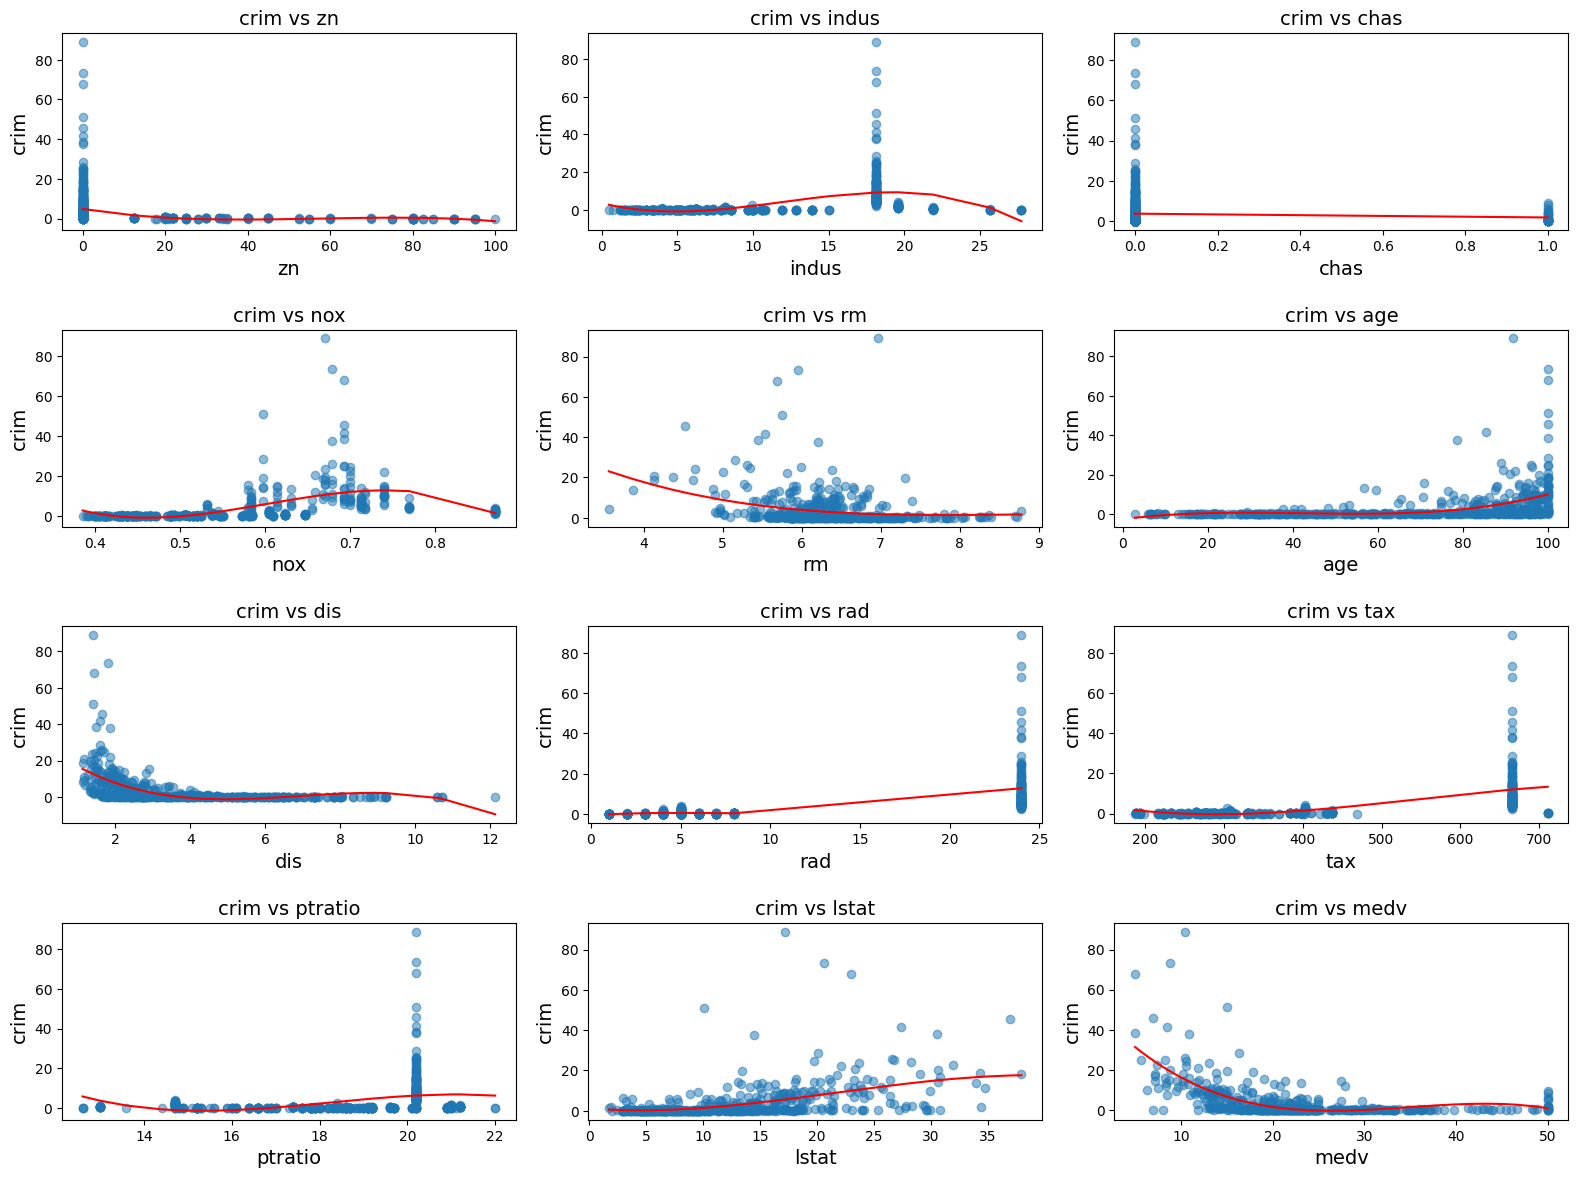

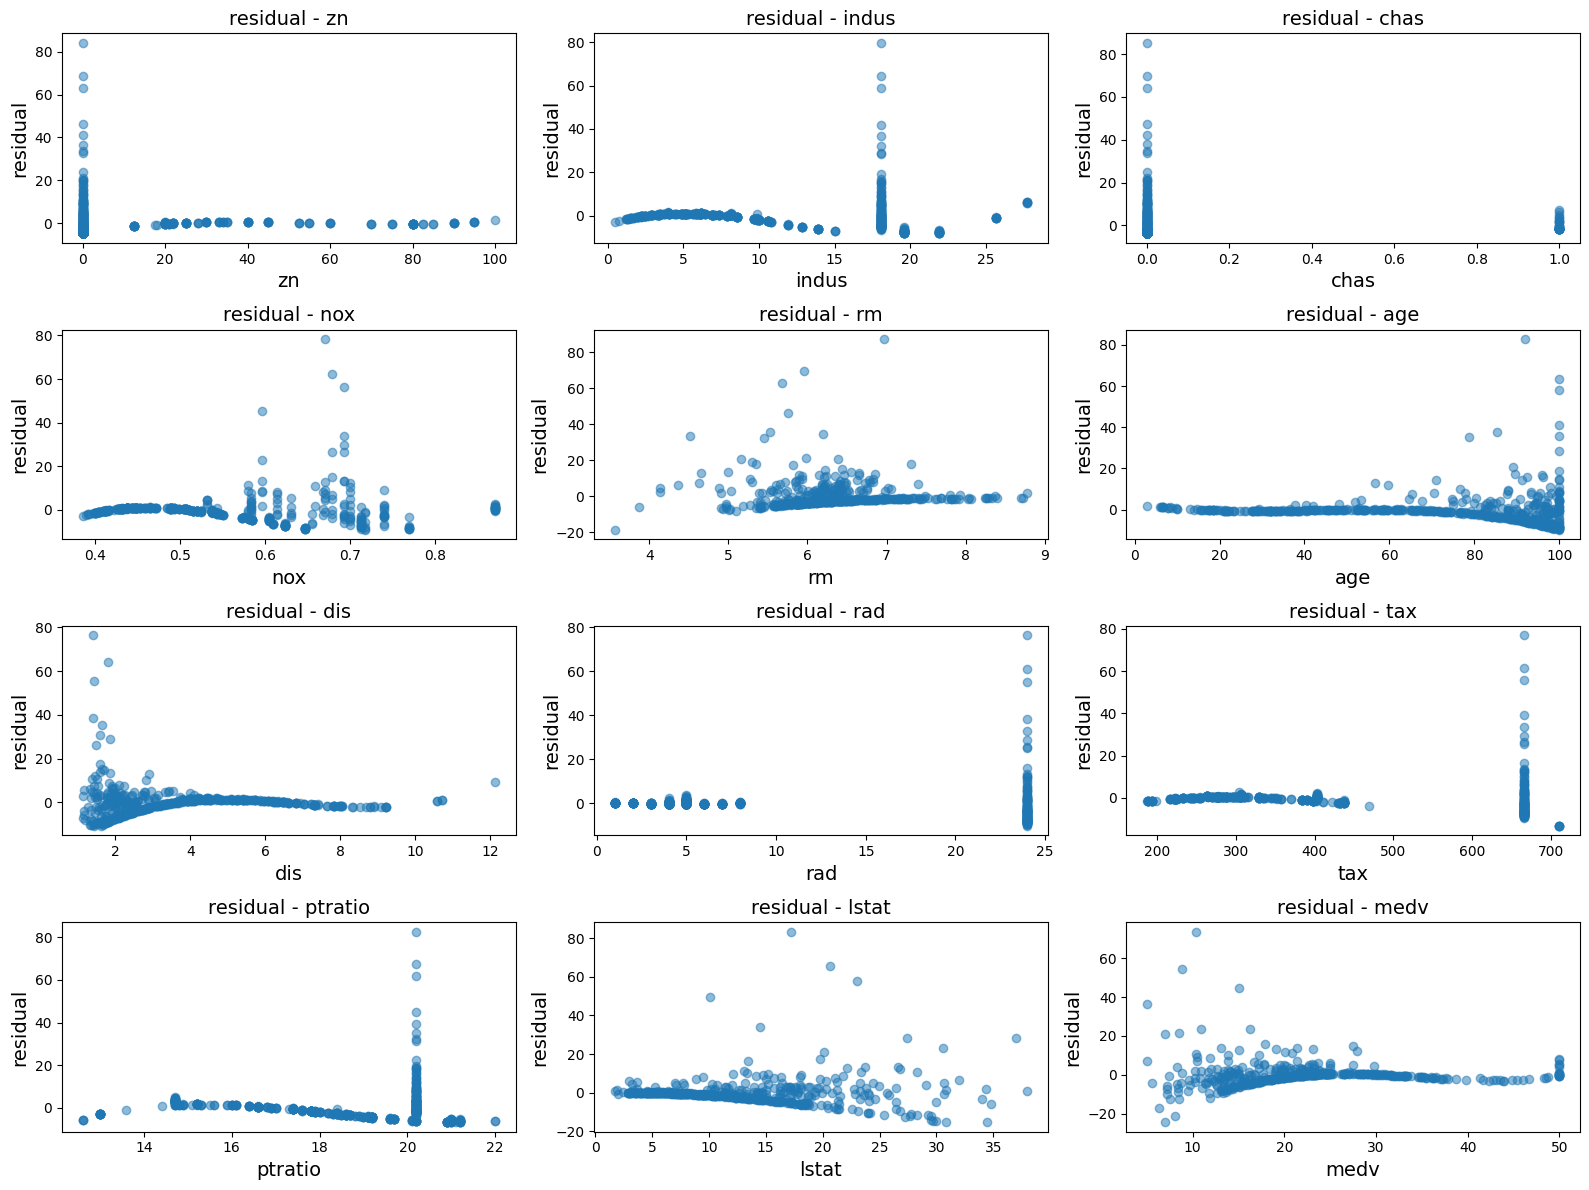

   predictor  r_squared
11      medv   0.420200
7        rad   0.400037
8        tax   0.368882
3        nox   0.296978
6        dis   0.277825
1      indus   0.259658
10     lstat   0.217932
5        age   0.174231
9    ptratio   0.113782
4         rm   0.067786
0         zn   0.058242
2       chas   0.003124


In [277]:
# Create subplot grid
n_cols = 3
n_rows = (n_predictors + n_cols - 1) // n_cols
fig_1, axes_1 = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes_1 = axes_1.flatten()

fig_2, axes_2 = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes_2 = axes_2.flatten()


models = {}
r_squared = []
for i, col_name in enumerate(predictors):
    if col_name == 'crim':
        continue
    X = bos[col_name].values
    X2 = X**2
    X3 = X**3
    intercept = np.ones(len(X))
    X = np.column_stack((intercept, X, X2, X3))
    _df = pd.DataFrame(X)
    _df.columns = ['intercept', col_name, f'{col_name}^2', f'{col_name}^3']
    model = smf.OLS(bos['crim'], _df).fit()
    models[col_name] = model
    predictions = model.predict(X)
    residual = bos['crim'] - predictions
    r_squared.append(model.rsquared)

    print(f"Model for {col_name}:")
    print("="*60)
    param_summary, model_summary = summarize(model, verbose=False)
    display(param_summary)
    display(model_summary)
    print("\n")


    axes_1[i].scatter(bos[col_name], bos['crim'], alpha=0.5)
    axes_1[i].plot(bos[col_name].sort_values(), predictions[bos[col_name].argsort()], color='red')
    axes_1[i].set_xlabel(col_name, fontsize=14)
    axes_1[i].set_ylabel('crim', fontsize=14)
    axes_1[i].set_title(f'crim vs {col_name}', fontsize=14)

    axes_2[i].scatter(bos[col_name], residual, alpha=0.5)
    axes_2[i].set_xlabel(col_name, fontsize=14)
    axes_2[i].set_ylabel('residual', fontsize=14)
    axes_2[i].set_title(f'residual - {col_name}', fontsize=14)

fig_1.tight_layout(pad=1.5, h_pad=2, w_pad=1)
fig_1.savefig('../images/3_15_d_scatter.png', dpi=300, bbox_inches='tight')

fig_2.tight_layout(pad=1.5, h_pad=2, w_pad=1)
fig_2.savefig('../images/3_15_d_residuals.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

r_squared_df = pd.DataFrame({'predictor': predictors, 'r_squared': r_squared})
r_squared_df = r_squared_df.sort_values(by='r_squared', ascending=False)
print(r_squared_df)

---
## ESL 3.17

Repeat the analysis of Table 3.3 on the spam data discussed in Chapter 1. Include LS, Best Subset, Ridge regression, and Lasso. (skip PCR and PLS)


### Solution

Pipeline:
1. standardize data (z norm; mean 0, std 1)
2. Fit model
3. Display
    * intercept
    * coefs
    * test error
    * std error

Methods:
1. LS
2. Best Subset
    * Best-subset selection drops all variables with coefficients smaller than the Mth largest; this is a form of “hard-thresholding.”
3. Ridge regression
    $$
        \hat{\beta}^{\mathrm{ridge}} = 
        \underset{\beta}{\mathrm{argmin}} \left\{
            \sum_{i=1}^N 
            \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 
            + \lambda \sum_{j=1}^p \beta_j^2
        \right\}
        \qquad \text{with } \lambda \geq 1
    $$

    which can be written in matrix form as 
    $$
        \mathrm{RSS}(\lambda) = 
        \left(\mathbf{y} - \mathbf{X}\beta\right)^T 
            \left(\mathbf{y} - \mathbf{X}\beta\right) + 
                \lambda\beta^2\beta
    $$
    with
    $$
        \hat{\beta}^{ridge} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
    $$

4. Lasso

    Similar to ridge but with an $\mathrm{L}_1$ penelty instead of $\mathrm{L}_2$:
    $$
        \hat{\beta}^{\mathrm{lasso}} = 
        \underset{\beta}{\mathrm{argmin}} \left\{
            \sum_{i=1}^N 
            \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 
        \right\} 
    $$
    $$
        \text{subject to } \, \sum_{j=1}^p|\beta_j| \leq t
    $$

    or equivalently in *Lagrangian form*
    $$
        \hat{\beta}^{\mathrm{ridge}} = 
        \underset{\beta}{\mathrm{argmin}} \left\{
            \frac{1}{2}\sum_{i=1}^N 
            \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 
            + \lambda \sum_{j=1}^p |\beta_j|
        \right\}
        \qquad \text{with } \lambda \geq 1
    $$

    **NOTE**: &nbsp;&nbsp; t should be adaptively chosen to minimize an estimate of expected prediction error.

    **NOTE**: &nbsp;&nbsp; Ridge regression does a proportional shrinkage. Lasso translates each coefficient by a constant factor λ, truncating at zero (“soft thresholding)

In [ ]:
# ESL 3.17 solution code
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

spambase = fetch_ucirepo(id=94)
scaler = StandardScaler()

X = spambase.data.features
y = spambase.data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'LS': {
        'model': LinearRegression(),
        'param_grid': {}
    },
    'ridge': {
        'model': Ridge(),
        'param_grid': {'alpha': np.concatenate([np.arange(0.005,10, 0.05), np.arange(10,2000,10)]), "max_iter": [1000]}
    },
    'lasso': {
        'model': Lasso(),
        'param_grid': {'alpha': np.concatenate([np.arange(0.01,.1, 0.001), np.arange(1,2000,10)]), 'max_iter': [1000]}
    },
}

results = {"name": [], "model": [], "intercept": [], "coefficients": [], "test_error": [], "test_R2": []}
for name, model in models.items():
    print()
    print(name)
    print("="*60)
    opt_param = {}

    if model["param_grid"]:
        grid_search = GridSearchCV(model["model"], param_grid=model["param_grid"], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)
        opt_param = {
            "alpha": grid_search.best_params_['alpha'],
            "max_iter": grid_search.best_params_['max_iter']
        }
        
    
    model = model["model"].set_params(**opt_param)
    model.fit(X_train_scaled, y_train)

    test_pred = model.predict(X_test_scaled)
    test_error = mean_squared_error(y_test, test_pred)
    test_R2 = r2_score(y_test, test_pred)

    print(test_R2)
    
    results["name"].append(name)
    results["model"].append(model)
    results["intercept"].append(model.intercept_[0])
    results["coefficients"].append(model.coef_.flatten())
    results["test_error"].append(test_error)
    results["test_R2"].append(test_R2)




LS
0.5419084922652304

ridge
0.5450095688309244

lasso
0.53022005140026


In [ ]:
coefs = np.column_stack([arr for arr in results["coefficients"]])
coefs = np.vstack([results["intercept"], coefs])

cols = X.columns.to_list()
cols = ['intercept'] + cols

model_names = results["name"]

df = pd.DataFrame(coefs, index=cols, columns=model_names)

# Split features into 10 groups
n_features = len(df)
chunk_size = (n_features + 9) // 10  # ceiling division for 10 chunks

fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()  # Convert 2D array to 1D

for i, ax in enumerate(axes):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, n_features)
    
    df.iloc[start:end].plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_ylabel('Coefficient Value')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.legend(title='Model', loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    
    for label in ax.get_xticklabels():
        label.set_ha('right')

axes[0].set_title('Coefficients by Feature')

plt.tight_layout()
plt.show()